# Multi-fidelity Multi-objective Bayesian Optimization

Here we attempt to solve for the constrained Pareto front of the TNK multi-objective
optimization problem using Multi-Fidelity Multi-Objective Bayesian optimization. For
simplicity we assume that the objective and constraint functions at lower fidelities is
exactly equal to the functions at higher fidelities (this is obviously not a
requirement, although for the best results lower fidelity calculations should
correlate with higher fidelity ones). The algorithm should learn this relationship
and use information gathered at lower fidelities to gather samples to improve the
hypervolume of the Pareto front at the maximum fidelity.

TNK function
$n=2$ variables:
$x_i \in [0, \pi], i=1,2$

Objectives:
- $f_i(x) = x_i$

Constraints:
- $g_1(x) = -x_1^2 -x_2^2 + 1 + 0.1 \cos\left(16 \arctan \frac{x_1}{x_2}\right) \le 0$
- $g_2(x) = (x_1 - 1/2)^2 + (x_2-1/2)^2 \le 0.5$

In [1]:
%reset -f

# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import torch

from xopt import Xopt, Evaluator
from xopt.generators.bayesian import MultiFidelityGenerator
from xopt.resources.test_functions.tnk import evaluate_TNK, tnk_vocs

evaluator = Evaluator(function=evaluate_TNK)
print(tnk_vocs.dict())

{'variables': {'x1': [0.0, 3.14159], 'x2': [0.0, 3.14159]}, 'constraints': {'c1': ['GREATER_THAN', 0.0], 'c2': ['LESS_THAN', 0.5]}, 'objectives': {'y1': 'MINIMIZE', 'y2': 'MINIMIZE'}, 'constants': {'a': 'dummy_constant'}, 'linked_variables': {}}


## Set up the Multi-Fidelity Multi-objective optimization algorithm
Here we create the Multi-Fidelity generator object which can solve both single and
multi-objective optimization problems depending on the number of objectives in VOCS.
We specify a cost function as a function of fidelity parameter $s=[0,1]$ as $C(s) =
s^{3.5}$ as an example from a real life multi-fidelity simulation problem.

In [2]:
options = MultiFidelityGenerator.default_options()
options.acq.reference_point = {"y1":1.5,"y2":1.5}

# set cost function according to approximate scaling of laser plasma accelerator
# problem, see https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.5.013063
options.acq.cost_function = lambda s: s**3.5
options.optim.num_restarts = 8
options.optim.raw_samples = 512

generator = MultiFidelityGenerator(tnk_vocs, options)
X = Xopt(generator=generator, evaluator=evaluator, vocs=tnk_vocs)

# evaluate at some explicit initial points
X.evaluate_data(pd.DataFrame({"x1":[1.0, 0.75],"x2":[0.75, 1.0],"s":[0.0,0.1]}))

X.generator.options.dict()

{'optim': {'num_restarts': 8,
  'raw_samples': 512,
  'sequential': True,
  'max_travel_distances': None,
  'use_turbo': False},
 'acq': {'proximal_lengthscales': None,
  'use_transformed_proximal_weights': True,
  'monte_carlo_samples': 128,
  'cost_function': <function __main__.<lambda>(s)>,
  'reference_point': {'y1': 1.5, 'y2': 1.5}},
 'model': {'name': 'standard',
  'custom_constructor': None,
  'use_low_noise_prior': True,
  'covar_modules': {},
  'mean_modules': {},
  'fidelity_parameter': 's'},
 'n_initial': 3,
 'use_cuda': False}

## Run optimization routine
Instead of ending the optimization routine after an explict number of samples we end
optimization once a given optimization budget has been exceeded. WARNING: This will
slightly exceed the given budget

In [3]:
budget = 10
while X.generator.calculate_total_cost() < budget:
    X.step()
    print(f"n_samples: {len(X.data)} "
          f"budget used: {X.generator.calculate_total_cost():.4} "
          f"hypervolume: {X.generator.calculate_hypervolume():.4}")

n_samples: 3 budget used: 0.007134 hypervolume: 0.0375
n_samples: 4 budget used: 0.01321 hypervolume: 0.1076
n_samples: 5 budget used: 0.02321 hypervolume: 0.1631
n_samples: 6 budget used: 0.0332 hypervolume: 0.1631
n_samples: 7 budget used: 0.0432 hypervolume: 0.2135
n_samples: 8 budget used: 0.0532 hypervolume: 0.2135
n_samples: 9 budget used: 0.0632 hypervolume: 0.2135
n_samples: 10 budget used: 0.07328 hypervolume: 0.2575
n_samples: 11 budget used: 0.09003 hypervolume: 0.2937
n_samples: 12 budget used: 0.1238 hypervolume: 0.2937
n_samples: 13 budget used: 0.1579 hypervolume: 0.2937
n_samples: 14 budget used: 0.2021 hypervolume: 0.3674
n_samples: 15 budget used: 0.2827 hypervolume: 0.4353
n_samples: 16 budget used: 0.3914 hypervolume: 0.5064
n_samples: 17 budget used: 0.721 hypervolume: 0.5064
n_samples: 18 budget used: 1.326 hypervolume: 0.6941
n_samples: 19 budget used: 2.14 hypervolume: 1.002
n_samples: 20 budget used: 3.14 hypervolume: 1.082
n_samples: 21 budget used: 4.14 hyper

## Show results

In [4]:
X.data

x1        x2         s        y1        y2        c1        c2   
1   1.000000  0.750000  0.000000  1.000000  0.750000  0.626888  0.312500  \
2   0.750000  1.000000  0.100000  0.750000  1.000000  0.626888  0.312500   
3   0.205026  1.765254  0.240455  0.205026  1.765254  2.185719  1.687877   
4   1.004109  0.677864  0.232694  1.004109  0.677864  0.567443  0.285761   
5   0.701670  0.809395  0.268275  0.701670  0.809395  0.105587  0.136396   
6   0.070692  0.494716  0.268171  0.070692  0.494716 -0.685827  0.184333   
7   0.338603  0.982118  0.268270  0.338603  0.982118  0.022767  0.258487   
8   0.774917  0.408123  0.268270  0.774917  0.408123 -0.242717  0.084021   
9   0.975040  0.370005  0.268275  0.975040  0.370005 -0.001085  0.242562   
10  1.018363  0.357866  0.268865  1.018363  0.357866  0.101129  0.288903   
11  1.087208  0.229457  0.310895  1.087208  0.229457  0.332940  0.418007   
12  0.814999  0.000000  0.379696  0.814999  0.000000 -0.435777  0.349224   
13  1.008845  0.051086  0.380986  1.008845  0.051086 -0.048606  0.460448   
14  0.896479  0.539867  0.410107  0.896479  0.539867  0.168156  0.158785   
15  0.796124  0.592610  0.487099  0.796124  0.592610  0.053701  0.096266   
16  1.004926  0.190769  0.530441  1.004926  0.190769  0.145292  0.350575   
17  0.881155  0.272858  0.728232  0.881155  0.272858 -0.158334  0.196873   
18  1.054950  0.243964  0.866320  1.054950  0.243964  0.260454  0.373524   
19  0.184523  0.989857  0.942826  0.184523  0.989857  0.112012  0.339485   
20  0.939790  0.469271  1.000000  0.939790  0.469271  0.060453  0.194359   
21  0.037145  0.955861  1.000000  0.037145  0.955861 -0.166253  0.422044   
22  1.038450  0.079591  0.931253  1.038450  0.079591  0.050716  0.466672   
23  0.600618  0.880577  0.299094  0.600618  0.880577  0.234994  0.154963   
24  0.407374  0.767172  1.000000  0.407374  0.767172 -0.249860  0.079961   
25  0.394904  0.887684  1.000000  0.394904  0.887684 -0.147617  0.161344   
26  0.086627  1.045348  0.992866  0.086627  1.045348  0.075718  0.468282   
27  0.677736  0.737894  0.679174  0.677736  0.737894 -0.073974  0.088184   
28  1.031220  0.038706  0.397195  1.031220  0.038706 -0.017606  0.494987   
29  1.043798  0.062126  1.000000  1.043798  0.062126  0.035302  0.487450   
30  0.523542  0.847710  0.364631  0.523542  0.847710  0.076755  0.121457   
31  0.832182  0.524330  0.545539  0.832182  0.524330  0.058384  0.110936   
32  0.769082  0.637040  0.573155  0.769082  0.637040 -0.009958  0.091185   
33  0.557861  0.807512  0.456874  0.557861  0.807512  0.060224  0.097912   
34  0.556578  0.837184  0.666052  0.556578  0.837184  0.110587  0.116894   
35  0.977872  0.171508  0.394034  0.977872  0.171508  0.079110  0.336269   
36  0.288617  0.912293  0.613948  0.288617  0.912293 -0.103311  0.214668   

   some_array  xopt_runtime  xopt_error               a  
1   [1, 2, 3]      0.000052       False             NaN  
2   [1, 2, 3]      0.000013       False             NaN  
3   [1, 2, 3]      0.000041       False  dummy_constant  
4   [1, 2, 3]      0.000040       False  dummy_constant  
5   [1, 2, 3]      0.000040       False  dummy_constant  
6   [1, 2, 3]      0.000040       False  dummy_constant  
7   [1, 2, 3]      0.000039       False  dummy_constant  
8   [1, 2, 3]      0.000039       False  dummy_constant  
9   [1, 2, 3]      0.000042       False  dummy_constant  
10  [1, 2, 3]      0.000040       False  dummy_constant  
11  [1, 2, 3]      0.000041       False  dummy_constant  
12  [1, 2, 3]      0.000042       False  dummy_constant  
13  [1, 2, 3]      0.000040       False  dummy_constant  
14  [1, 2, 3]      0.000048       False  dummy_constant  
15  [1, 2, 3]      0.000041       False  dummy_constant  
16  [1, 2, 3]      0.000042       False  dummy_constant  
17  [1, 2, 3]      0.000040       False  dummy_constant  
18  [1, 2, 3]      0.000042       False  dummy_constant  
19  [1, 2, 3]      0.000043       False  dummy_constant  
20  [1, 2, 3]      0.000042       Fal

## Plot results
Here we plot the resulting observations in input space, colored by feasibility
(neglecting the fact that
these data points are at varying fidelities).


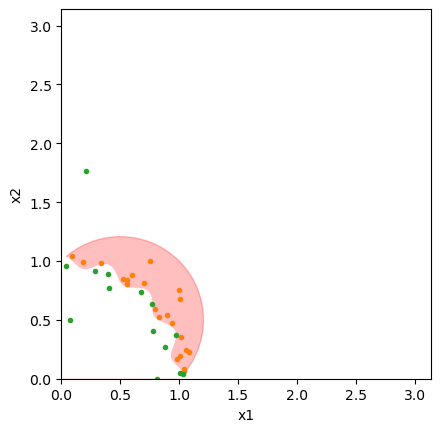

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

theta = np.linspace(0, np.pi / 2)
r = np.sqrt(1 + 0.1 * np.cos(16 * theta))
x_1 = r * np.sin(theta)
x_2_lower = r * np.cos(theta)
x_2_upper = (0.5 - (x_1 - 0.5) ** 2) ** 0.5 + 0.5

z = np.zeros_like(x_1)

# ax2.plot(x_1, x_2_lower,'r')
ax.fill_between(x_1, z, x_2_lower, fc="white")
circle = plt.Circle(
    (0.5, 0.5), 0.5 ** 0.5, color="r", alpha=0.25, zorder=0, label="Valid Region"
)
ax.add_patch(circle)
history = pd.concat(
    [X.data, tnk_vocs.feasibility_data(X.data)], axis=1, ignore_index=False
)

ax.plot(*history[["x1", "x2"]][history["feasible"]].to_numpy().T, ".C1")
ax.plot(*history[["x1", "x2"]][~history["feasible"]].to_numpy().T, ".C2")

ax.set_xlim(0, 3.14)
ax.set_ylim(0, 3.14)
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_aspect("equal")

### Plot path through input space

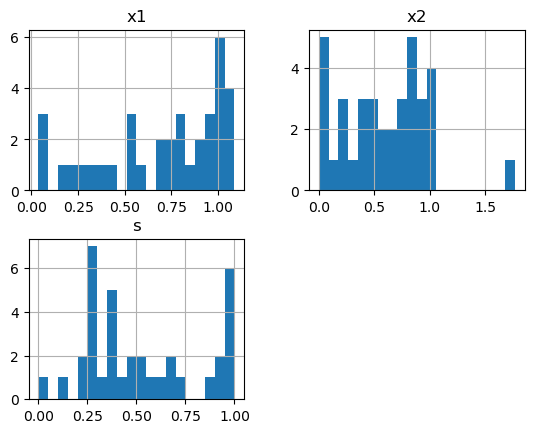

In [6]:
ax = history.hist(["x1", "x2", "s"],bins=20)

<Axes: >

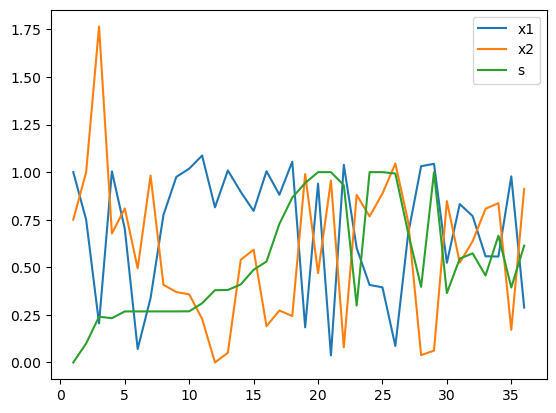

In [7]:
history.plot(y=["x1", "x2", "s"])

## Plot the acqusisition function
Here we plot the acquisition function at a small set of fidelities $[0, 0.5, 1.0]$.

[[0.53724914 0.81759748]]


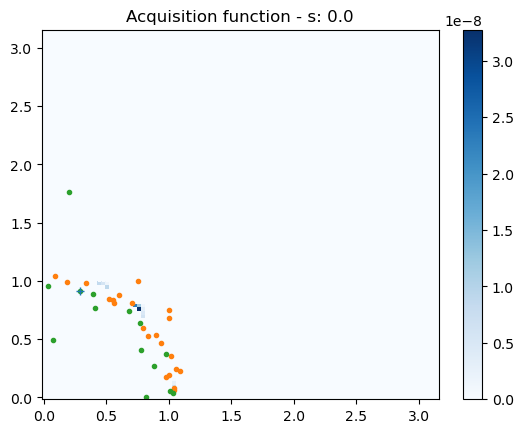

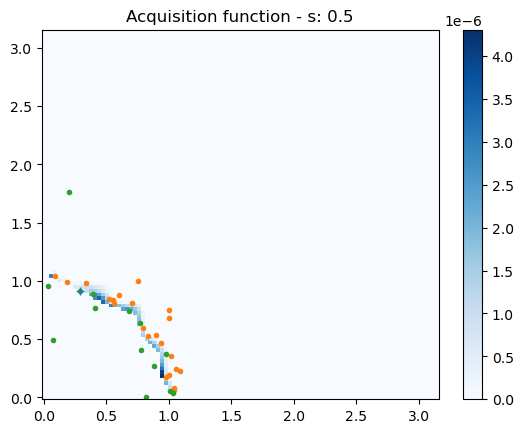

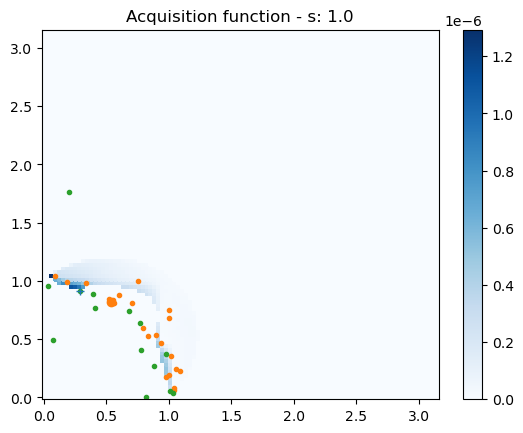

In [8]:
# plot the acquisition function
from xopt.generators.bayesian.objectives import feasibility

bounds = generator.vocs.bounds
model = generator.model

# create mesh over non-fidelity parameters
n = 100
x = torch.linspace(*bounds.T[1], n)
y = torch.linspace(*bounds.T[2], n)
xx, yy = torch.meshgrid(x, y)

# plot function(s) at a single fidelity parameter
fidelities = [0.0, 0.5, 1.0]
for fidelity in fidelities:
    pts = torch.hstack([ele.reshape(-1, 1) for ele in (xx, yy)]).double()
    pts = torch.cat((torch.ones(pts.shape[0],1)*fidelity, pts), dim=-1)

    acq_func = generator.get_acquisition(model)
    with torch.no_grad():
        acq_pts = pts.unsqueeze(1)
        acq = acq_func(acq_pts)

        fig, ax = plt.subplots()
        c = ax.pcolor(xx, yy, acq.reshape(n, n), cmap="Blues")
        fig.colorbar(c)
        ax.set_title(f"Acquisition function - s: {fidelity}")

        ax.plot(*history[["x1", "x2"]][history["feasible"]].to_numpy().T, ".C1")
        ax.plot(*history[["x1", "x2"]][~history["feasible"]].to_numpy().T, ".C2")

        ax.plot(*history[["x1", "x2"]].to_numpy()[-1].T, "+")


candidate = generator.generate(1)
print(candidate[["x1", "x2"]].to_numpy())
ax.plot(*candidate[["x1", "x2"]].to_numpy()[0], "o")

In [9]:
# examine lengthscale of the first objective
list(model.models[0].named_parameters())

[('likelihood.noise_covar.raw_noise',
  Parameter containing:
  tensor([-21.6744], dtype=torch.float64, requires_grad=True)),
 ('mean_module.raw_constant',
  Parameter containing:
  tensor(-0.0029, dtype=torch.float64, requires_grad=True)),
 ('covar_module.raw_outputscale',
  Parameter containing:
  tensor(0.8005, dtype=torch.float64, requires_grad=True)),
 ('covar_module.base_kernel.raw_lengthscale',
  Parameter containing:
  tensor([[0.8443, 1.4060, 1.5181]], dtype=torch.float64, requires_grad=True))]

In [10]:
# dump results to fiel
X.options.dump_file = "results.yaml"
X.dump_state()